#  Pedestrians in inner cities during the Corona crisis

Author: Andreas Traut

On Saturday 21.03.2020 exit locks had been implemented in order to protect the people from the Corona virus. I read an article about the company Hystreet (https://hystreet.com), who provides statistics about pedestrians in inner cities. Due to the implemented exit lock the number should decrease from 21.03.2020 onwards. Hystreet offers free downloadable csv files for private use. In this example I wanted to see these descresing numbers. So let's start: 

First I downloaded the csv Files for Ulm, Münsterplatz for several weeks (that's why I received one csv file for each week). Then I used Pandas "read_csv": 

In [1]:
import pandas as pd
from matplotlib import pyplot, dates
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import glob

#%% read all files
all_files = glob.glob("*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=';')
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

Now let's have a look at the data types: 

In [2]:
df.dtypes

location                object
time_of_measurement     object
counted_pedestrians      int64
type                    object
incidents              float64
dtype: object

In [3]:
df.head()

,location,time_of_measurement,counted_pedestrians,type,incidents
0,"Münsterplatz , Ulm",2020-02-17 00:01:56 +0100,3,regular,NaN
1,"Münsterplatz , Ulm",2020-02-17 00:08:37 +0100,1,regular,NaN
2,"Münsterplatz , Ulm",2020-02-17 00:17:02 +0100,1,regular,NaN
3,"Münsterplatz , Ulm",2020-02-17 00:23:57 +0100,1,regular,NaN
4,"Münsterplatz , Ulm",2020-02-17 00:34:54 +0100,2,regular,NaN


As we have "objects" I need to convert these columns. Additionally I want some new columns in order to analyze the data, for example the week-of-year number or the weekday. 

In [4]:
#%% convert and extract "date-times"
df['datenum'] = dates.datestr2num(df['time_of_measurement'])
df['date'] = df['time_of_measurement'].apply(pd.to_datetime, errors='coerce')
df['hour']= pd.DatetimeIndex(df['date']).hour
df['minute']= pd.DatetimeIndex(df['date']).minute
df['weekofyear'] = pd.DatetimeIndex(df['date']).weekofyear
df['weekday'] = pd.DatetimeIndex(df['date']).weekday #Monday=0
df['weekdayname'] = pd.DatetimeIndex(df['date']).day_name()

In [5]:
df.head()

,location,time_of_measurement,counted_pedestrians,type,incidents,datenum,date,hour,minute,weekofyear,weekday,weekdayname
0,"Münsterplatz , Ulm",2020-02-17 00:01:56 +0100,3,regular,NaN,737471.959676,2020-02-17 00:01:56+01:00,0,1,8,0,Monday
1,"Münsterplatz , Ulm",2020-02-17 00:08:37 +0100,1,regular,NaN,737471.964317,2020-02-17 00:08:37+01:00,0,8,8,0,Monday
2,"Münsterplatz , Ulm",2020-02-17 00:17:02 +0100,1,regular,NaN,737471.970162,2020-02-17 00:17:02+01:00,0,17,8,0,Monday
3,"Münsterplatz , Ulm",2020-02-17 00:23:57 +0100,1,regular,NaN,737471.974965,2020-02-17 00:23:57+01:00,0,23,8,0,Monday
4,"Münsterplatz , Ulm",2020-02-17 00:34:54 +0100,2,regular,NaN,737471.982569,2020-02-17 00:34:54+01:00,0,34,8,0,Monday


Now I am prepared for the analysis. But before I start, I defined some methods which help me to print some images: 

In [6]:
#%% define methods for printing images
sns.set(color_codes=True)
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return dates.num2date(x).strftime('%Y-%m-%d')

def print_image(selection, title):
    fig, ax = pyplot.subplots()
    ax.set_title(title)
    sns.lineplot(x=selection['datenum'], y=selection['counted_pedestrians'])
    
    #Create the x-axis which is 'datenum' converted to %Y-%m-%d
    ax.xaxis.set_major_formatter(FuncFormatter(fake_dates))
    ax.tick_params(labelrotation=90)
    fig.tight_layout()

Ok. Now it is very easy to examine the whole data. Let's do this: 

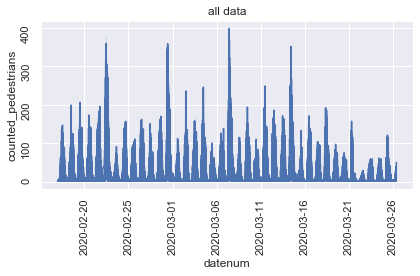

In [7]:
print_image(df, "all data")

You can already see, that from 21.03.2020 onwards the numbers decreased a lot. So the exit locks seem to work and people really stay at home. 

But what are the high spikes? Let's have a look: 

In [8]:
#%% sum of pedestrians per weekday
print(df.groupby(['weekday','weekdayname'])['counted_pedestrians'].sum())

weekday  weekdayname
0        Monday          68425
1        Tuesday         60360
2        Wednesday       87535
3        Thursday        54622
4        Friday          67413
5        Saturday       125978
6        Sunday          28403
Name: counted_pedestrians, dtype: int64


The high spikes seem to be "Saturdays". But these are aggregated numbers for several weeks. So it could be misleading. Let's have a closer look. I want to sea week-by-week the sum of pedestrians split up for each day: 

In [9]:
#%% sum of pedestrians per weekday and per week-of-year
print(df.groupby(['weekday','weekdayname','weekofyear']).
      agg( 
          sum_counted_pedestrians=('counted_pedestrians', sum)          
          )
      )

                                sum_counted_pedestrians
weekday weekdayname weekofyear                         
0       Monday      8                             10408
                    9                             13884
                    10                            12719
                    11                            12814
                    12                            13783
                    13                             4817
1       Tuesday     8                             13892
                    9                              9875
                    10                            13052
                    11                             8140
                    12                            10578
                    13                             4823
2       Wednesday   8                             14360
                    9                             15214
                    10                            17176
                    11                          

Now I am sure that the spikes are Saturdays as these are the highest numbers. And in week-of-year 13 (the first week with exit locks) the number of pedestrians is very low. That's what I wanted to see. 

We can also invert the "groupby" and examine the decrease week-by-week for each day: 

In [10]:
#%% sum of pedestrians per weekday and per week-of-year
print(df.groupby(['weekofyear','weekday','weekdayname']).
      agg( 
          sum_counted_pedestrians=('counted_pedestrians', sum)          
          )
      )

                                sum_counted_pedestrians
weekofyear weekday weekdayname                         
8          0       Monday                         10408
           1       Tuesday                        13892
           2       Wednesday                      14360
           3       Thursday                       13856
           4       Friday                         17606
           5       Saturday                       32911
           6       Sunday                          5601
9          0       Monday                         13884
           1       Tuesday                         9875
           2       Wednesday                      15214
           3       Thursday                        9844
           4       Friday                         15656
           5       Saturday                       29323
           6       Sunday                          6941
10         0       Monday                         12719
           1       Tuesday                      

I want to see these numbers in a barplot: 

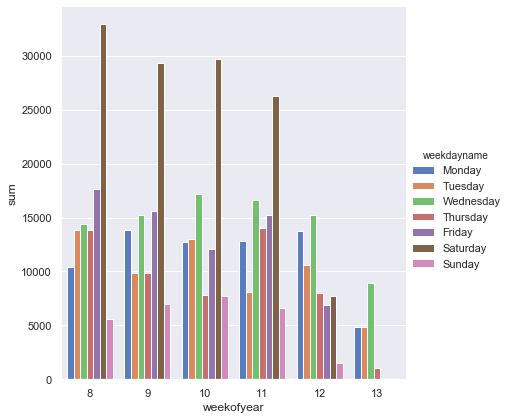

In [11]:
df_grouped=(df.groupby(['weekofyear', 'weekdayname'], as_index=False).counted_pedestrians.
            agg({'counted_pedestrians': lambda x: list(x), 'sum': 'sum'}))

sns.catplot(x='weekofyear', y='sum', hue='weekdayname', 
            hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
            data=df_grouped,
            height=6, kind='bar', palette='muted')

The exit locks have been implemented on Saturday 23.03, which is week 12. Yes, on Sunday of week 12 already I can see a lot fewer people walking on the inner city of Ulm, Münsterplatz. And in week 13 this trend continued. Nice. 

And finally let's plot these numbers day-by-day. I am glad that I have already defined the method "print_image" above, which I will use now: 

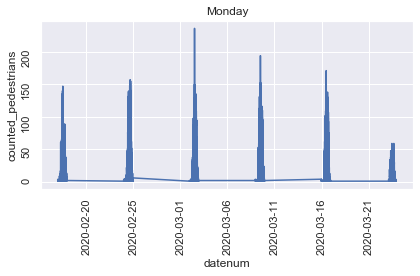

In [12]:
#%% print images for each day
print_image(df.loc[df['weekdayname'] == 'Monday'], "Monday")

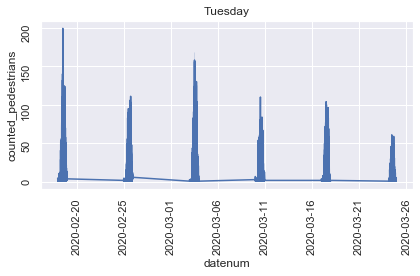

In [13]:
print_image(df.loc[df['weekdayname'] == 'Tuesday'], "Tuesday")

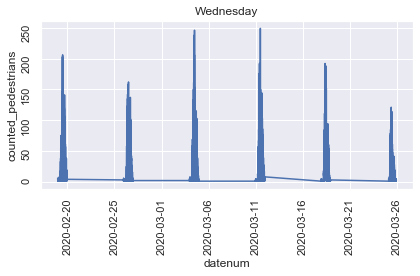

In [14]:
print_image(df.loc[df['weekdayname'] == 'Wednesday'], "Wednesday")

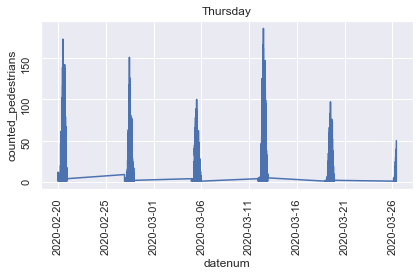

In [15]:
print_image(df.loc[df['weekdayname'] == 'Thursday'], "Thursday")

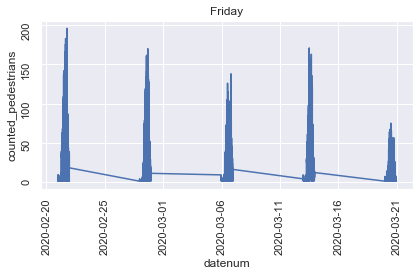

In [16]:
print_image(df.loc[df['weekdayname'] == 'Friday'], "Friday")

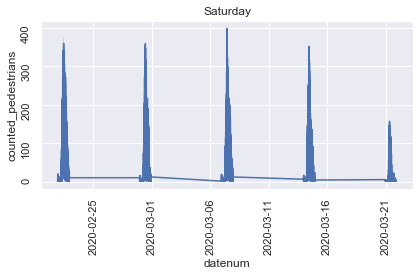

In [17]:
print_image(df.loc[df['weekdayname'] == 'Saturday'], "Saturday")

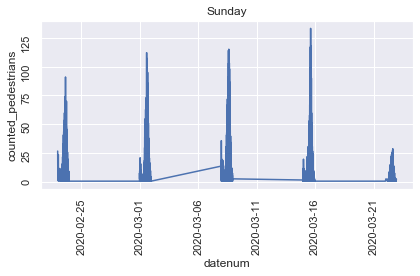

In [18]:
print_image(df.loc[df['weekdayname'] == 'Sunday'], "Sunday")

Ok, this proves, that the exit locks are working and people are staying at home. But what about analyzing the data for a longer period. I wanted to know this and downloaded the data from 27 August 2019 to 26 March 2020. 

In [19]:
all_files = glob.glob("Aug2019bisheute/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep=';')
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

As my timeseries included now as well sommertime as also wintertime I had to include the "utc=True". Otherwiese I get the error message: 

ValueError: Tz-aware datetime.datetime cannot be converted to datetime64 unless utc=True

In [23]:
df['datenum'] = dates.datestr2num(df['time_of_measurement'])
df['date'] = df['time_of_measurement'].apply(pd.to_datetime, errors='coerce', utc=True)
df['hour']= pd.DatetimeIndex(df['date']).hour
df['minute']= pd.DatetimeIndex(df['date']).minute
df['year']= pd.DatetimeIndex(df['date']).year
df['weekofyear'] = pd.DatetimeIndex(df['date']).weekofyear
df['weekday'] = pd.DatetimeIndex(df['date']).weekday #Monday=0
df['weekdayname'] = pd.DatetimeIndex(df['date']).day_name()

Next I grouped the data by "locaction", "year" and so on.

Text(0.5, 1, 'Total')

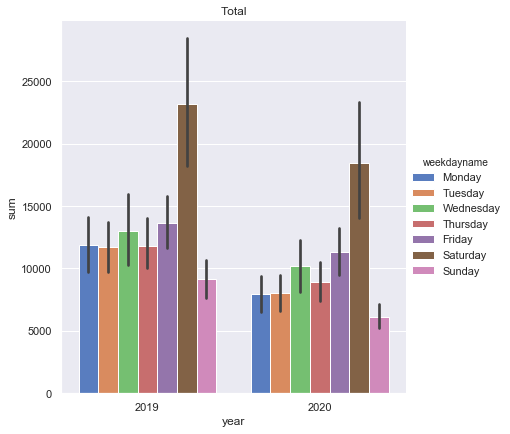

In [25]:
df_grouped=(df.groupby(['location', 'year','weekofyear', 'weekdayname'], as_index=False).counted_pedestrians.
            agg({'counted_pedestrians': lambda x: list(x), 'sum': 'sum'}))

sns.catplot(x='year', y='sum', hue='weekdayname', 
                hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                data= df_grouped,
                height=6, kind='bar', palette='muted')

pyplot.title("Total")

Next I wanted to have plots split up by location. Therefore I used the "factorize" in order to get all different locations: 

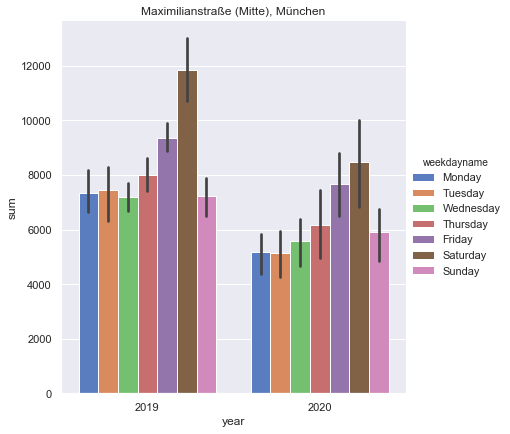

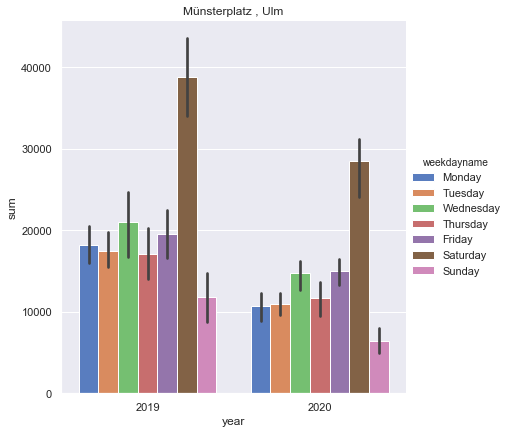

In [26]:
df_grouped_encoded, df_grouped_categories = df['location'].factorize()

for i in range(len(df_grouped_categories)): 
    df_plot = df_grouped[df_grouped['location']==df_grouped_categories[i]]

    sns.catplot(x='year', y='sum', hue='weekdayname', 
                hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                data= df_plot,
                height=6, kind='bar', palette='muted')

    pyplot.title(df_grouped_categories[i])


I think I should avoid interpreting too much into these plots. The 2019 figures contain 126 days (from 27.08.2019 to 31.12.2019), which is 4 months and the 2020 figures 85 days (from 01.01.2020 to 26.03.2020), which is 3 months. Of course the bars are higher in 2019 than 2020 because of this. 

Thank you also to "Hystreet" (https://hystreet.com), for the data. 